<a href="https://colab.research.google.com/github/PunitRaveendran/ACM/blob/main/Facial%20Emotion%20Recognition%20(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 1


Epoch [1/10], Loss: 0.0000
Epoch [2/10], Loss: 0.0000
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000

Evaluating the model...
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Plotting training loss...


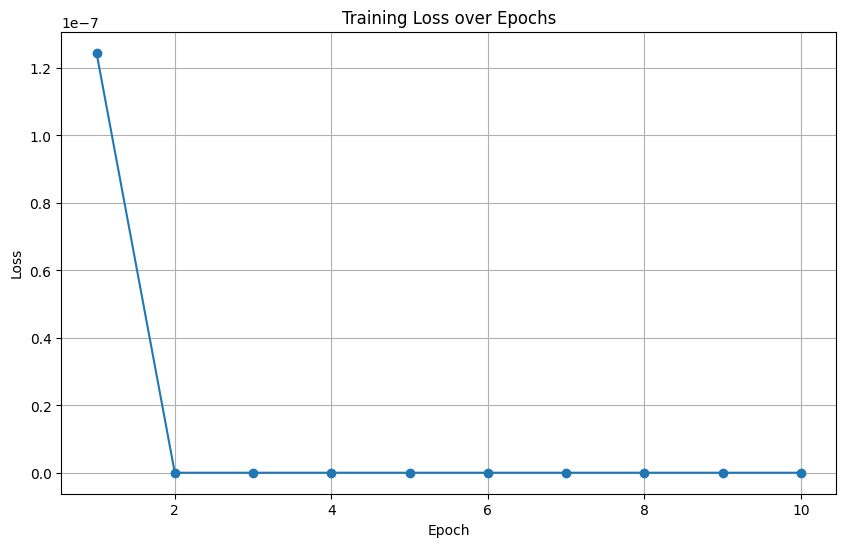

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import zipfile

try:
    with zipfile.ZipFile('archive.zip', 'r') as z:
        books_df = pd.read_csv(z.open('books.csv'))
        ratings_df = pd.read_csv(z.open('ratings.csv'))
        to_read_df = pd.read_csv(z.open('to_read.csv'))
        book_tags_df = pd.read_csv(z.open('book_tags.csv'))
        tags_df = pd.read_csv(z.open('tags.csv'))

except FileNotFoundError:
    print("Error: archive.zip not found. Please ensure the file is accessible.")
    exit()
except KeyError as e:
    print(f"Error: File not found within the zip archive: {e}. Please check the file names and paths inside the zip.")
    exit()


# Filtering out books with missing essential information
books_df.dropna(subset=['original_publication_year', 'average_rating', 'ratings_count'], inplace=True)

# now we merge books with tags to get genre information
book_tags_df = book_tags_df.merge(tags_df, on='tag_id')

# then the top 100 most popular tags (genres) to use as features
popular_tags = book_tags_df['tag_name'].value_counts().nlargest(100).index
book_tags_filtered = book_tags_df[book_tags_df['tag_name'].isin(popular_tags)]

genre_features = book_tags_filtered.pivot_table(index='goodreads_book_id', columns='tag_name', values='count', fill_value=0)
genre_features = genre_features.reset_index().rename(columns={'goodreads_book_id': 'book_id'})

# Merge book metadata with genre features
books_with_genres_df = books_df.merge(genre_features, on='book_id', how='left')
books_with_genres_df.fillna(0, inplace=True)  # Filling NaNs for books without any popular tags

# Label Creation
# Create a unique identifier for each user-book interaction
ratings_df['user_book_id'] = ratings_df['user_id'].astype(str) + '_' + ratings_df['book_id'].astype(str)
to_read_df['user_book_id'] = to_read_df['user_id'].astype(str) + '_' + to_read_df['book_id'].astype(str)

# Create a DataFrame for "finished" books (label = 1) from the ratings data
finished_books_df = ratings_df.copy()
finished_books_df['label'] = 1

# Creating a DataFrame for "dropped" books (label = 0)
# A book is considered dropped if it's in the to_read list but not in the ratings list
rated_user_book_ids = set(ratings_df['user_book_id'])
dropped_books_df = to_read_df[~to_read_df['user_book_id'].isin(rated_user_book_ids)].copy()
dropped_books_df['label'] = 0

# Merging the finished and dropped datasets
dataset_df = pd.concat([finished_books_df, dropped_books_df], ignore_index=True)
# Merge with book features
final_df = dataset_df.merge(
    books_with_genres_df, on='book_id', how='left'
)
final_df.dropna(inplace=True) # Drop any rows where book features were not found
# Feature and Label Preparation for PyTorch
# Select numerical and genre features
numerical_features = ['average_rating', 'ratings_count', 'work_ratings_count', 'work_text_reviews_count', 'original_publication_year', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']
genre_features_list = popular_tags.tolist()

# Add the user's rating as a feature for the finished books
final_df['user_rating'] = final_df['rating'].fillna(0)
features_list = numerical_features + genre_features_list + ['user_rating']

X = final_df[features_list].values
y = final_df['label'].values

# Standardize numerical features
scaler = StandardScaler()
X[:, :len(numerical_features)] = scaler.fit_transform(X[:, :len(numerical_features)])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create a custom PyTorch Dataset
class DropoutDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = DropoutDataset(X_train_tensor, y_train_tensor)
test_dataset = DropoutDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Model Definition
# Multilayer Perceptron with ReLU hidden layers and Sigmoid output
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        # We don't apply Sigmoid here, we use BCEWithLogitsLoss which combines Sigmoid and Binary Cross Entropy
        x = self.output_layer(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train_tensor.shape[1]
model = MLP(input_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Model Training
num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * features.size(0)

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
# Model Evaluation
print("\nEvaluating the model...")
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        predictions = (torch.sigmoid(outputs) > 0.5).int()
        all_predictions.extend(predictions.numpy().flatten())
        all_labels.extend(labels.numpy().flatten())

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

#Loss Visualization
print("\nPlotting training loss...")
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Phase 2

Epoch 1,Loss:52137.107,Accuracy:0.263
Epoch 2,Loss:48272.769,Accuracy:0.322
Epoch 3,Loss:46068.411,Accuracy:0.356
Epoch 4,Loss:44853.590,Accuracy:0.377
Epoch 5,Loss:44179.883,Accuracy:0.386
Epoch 6,Loss:43701.347,Accuracy:0.391
Epoch 7,Loss:43237.420,Accuracy:0.402
Epoch 8,Loss:42824.540,Accuracy:0.403
Epoch 9,Loss:42452.121,Accuracy:0.411
Epoch 10,Loss:42308.642,Accuracy:0.417
Training Complete
Testing Accuracy0.489


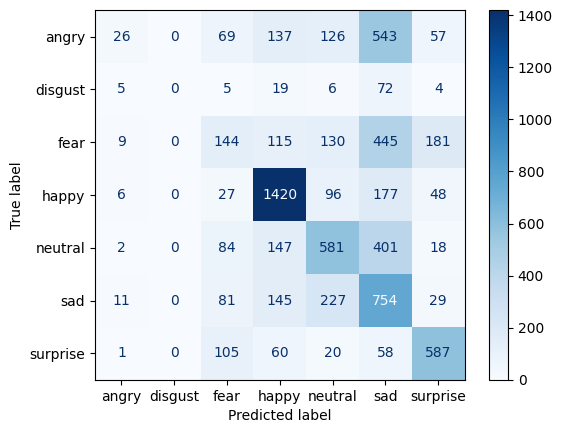

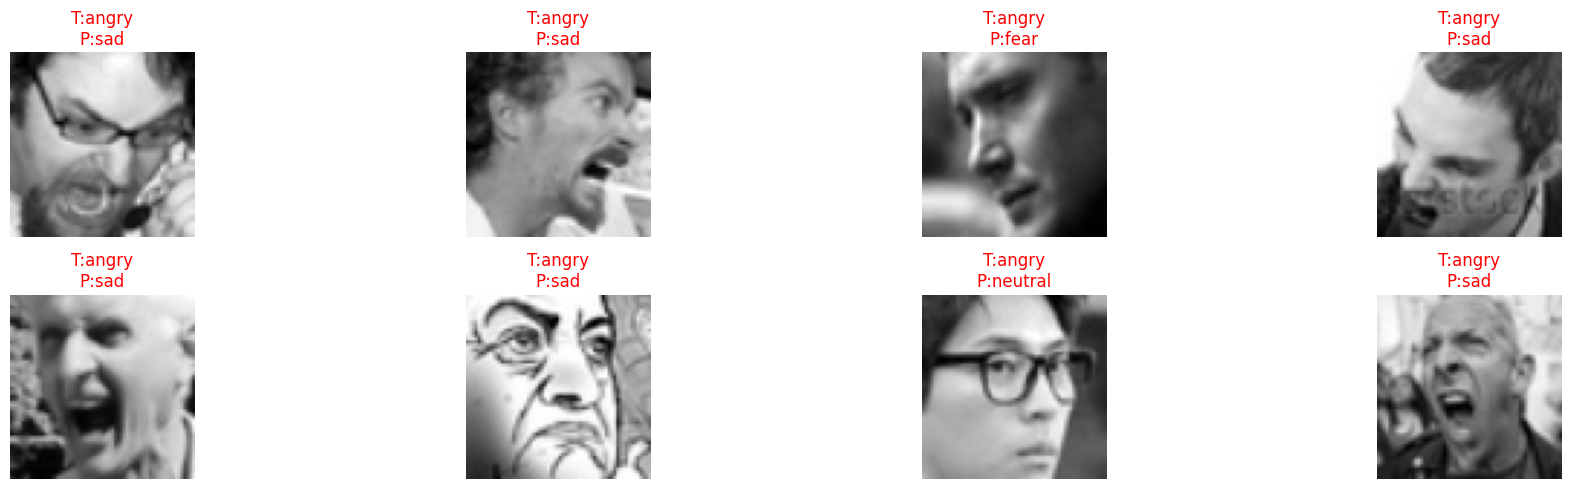

In [14]:
import zipfile
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms,datasets
from torch import nn,optim
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


zip_path = "/content/archive (1).zip"
extract_path = "/content/extracted_archive"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
transform_train =transforms.Compose([
    transforms.Resize((64,64)),
    transforms.Grayscale(), # Add grayscale transformation
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
transform_test = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.Grayscale(), # Add grayscale transformation
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
train_dataset = datasets.ImageFolder('/content/extracted_archive/train',transform=transform_train)
test_dataset = datasets.ImageFolder('/content/extracted_archive/test',transform=transform_test)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=False)
class_names = train_dataset.classes

class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128*8*8, 256), # Corrected input size for linear layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 7)
        )

    def forward(self, x):
        x = self.conv1(x)
        # print("Shape after conv layers:", x.shape) # Remove or comment out the print statement
        x = x.view(x.size(0), -1)
        return self.fc(x)

def train_model(model,epoch = 10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=0.001)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epoch):
        model.train()
        run_loss,correct = 0, 0

        for inputs,labels in train_loader:
            inputs,labels = inputs.to(device),labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            run_loss += loss.item() * inputs.size(0)
            _,preds = torch.max(outputs,1)
            correct += torch.sum(preds == labels.data)

        acc = correct.double()/len(train_loader.dataset)
        print(f"Epoch {epoch+1},Loss:{run_loss:.3f},Accuracy:{acc:.3f}")

    print("Training Complete")

def evaluate_model(model):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.eval()
  all_preds,all_labels = [],[]
  with torch.no_grad():
    for inputs,labels in test_loader:
      inputs,labels = inputs.to(device),labels.to(device)
      outputs = model(inputs)
      _,preds = torch.max(outputs,1)
      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())
  accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
  print(f"Testing Accuracy{accuracy:.3f}")
  cm = confusion_matrix(all_labels,all_preds)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues,values_format='d')
  plt.show()

def Visualize_prediction(model,n=8):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.eval()
  images_shown = 0
  fig, axs = plt.subplots(2,n//2, figsize=(20,5))
  with torch.no_grad():
    for inputs,labels in test_loader:
      inputs,labels = inputs.to(device),labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs,1)

      for i in range(inputs.size(0)):
        if images_shown >= n:
          break
        ax = axs[images_shown//(n//2),images_shown%(n//2)]
        img = inputs[i].cpu().squeeze().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"T:{class_names[labels[i]]}\nP:{class_names[preds[i]]}",color='green' if preds[i] == labels[i] else 'red')
        ax.axis('off')
        images_shown += 1
  plt.tight_layout()
  plt.show()


model = EmotionCNN()
train_model(model,epoch = 10)
evaluate_model(model)
Visualize_prediction(model,n=8)

# Phase 3

In [7]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from tqdm import tqdm

# === 1. Load & preprocess ===
df = pd.read_csv("emotion_dataset_raw.csv")
df['Text'] = df['Text'].astype(str)

# Label encode
le = LabelEncoder()
df['label'] = le.fit_transform(df['Emotion'])

# Simple tokenizer
def tokenize(text): return text.lower().split()

# Build vocab
tokens = [token for text in df['Text'] for token in tokenize(text)]
vocab = {"<PAD>": 0, "<UNK>": 1}
vocab.update({w: i + 2 for i, (w, _) in enumerate(Counter(tokens).most_common(8000))})

# Encode text
def encode(text): return [vocab.get(w, 1) for w in tokenize(text)]
df['input_ids'] = df['Text'].apply(encode)

# Split
X_train, X_test, y_train, y_test = train_test_split(df['input_ids'], df['label'], test_size=0.2, stratify=df['label'])

# === 2. Dataset ===
class EmotionDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor(x) for x in texts]
        self.labels = torch.tensor(labels.values)

    def __getitem__(self, idx): return self.texts[idx], self.labels[idx]
    def __len__(self): return len(self.labels)

def pad_collate(batch):
    texts, labels = zip(*batch)
    padded = pad_sequence(texts, batch_first=True)
    return padded, torch.tensor(labels)

train_dl = DataLoader(EmotionDataset(X_train, y_train), batch_size=64, shuffle=True, collate_fn=pad_collate)
test_dl  = DataLoader(EmotionDataset(X_test, y_test), batch_size=64, collate_fn=pad_collate)

# === 3. Model ===
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, out_dim):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.emb(x)
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])

model = LSTM(len(vocab), 100, 128, len(le.classes_)).to("cpu")
opt = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

# === 4. Train ===
for epoch in range(3):
    model.train()
    for X, y in train_dl:
        opt.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        opt.step()
    print(f"Epoch {epoch+1} complete")

# === 5. Evaluate ===
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for X, y in test_dl:
        logits = model(X)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_true.extend(y.tolist())

print("Accuracy:", accuracy_score(all_true, all_preds))
print("F1 Score:", f1_score(all_true, all_preds, average='weighted'))

# Sample Predictions
print("\nSample Predictions:")
for i in range(10):
    text_tokens = X_test.iloc[i]
    text_tensor = torch.tensor(text_tokens).unsqueeze(0)
    padded = pad_sequence([text_tensor.squeeze()], batch_first=True)

    model.eval()
    with torch.no_grad():
        output = model(padded)
        pred_label = output.argmax(dim=1).item()

    input_words = [word for word, idx in vocab.items() if idx in text_tokens][:15]
    print(f"Text: {' '.join(input_words)}...")
    print(f"Actual: {le.inverse_transform([y_test.iloc[i]])[0]} | Predicted: {le.inverse_transform([pred_label])[0]}\n")

Epoch 1 complete
Epoch 2 complete
Epoch 3 complete
Accuracy: 0.4095416008047133
F1 Score: 0.361740327584308

Sample Predictions:
Text: i like now how feel felt u wish knew crying rite...
Actual: sadness | Predicted: sadness

Text: <UNK> a me no de la que un con o para mañana algo e. x)...
Actual: fear | Predicted: fear

Text: <UNK> get they them while candy last. cane...
Actual: joy | Predicted: fear

Text: a and on this all been even never i've talk date romance...
Actual: sadness | Predicted: joy

Text: the i to . , for was it with but up out an over yes...
Actual: sadness | Predicted: sadness

Text: <UNK> my out found wife pregnant....
Actual: joy | Predicted: sadness

Text: a . for go ’ let s joy ride...
Actual: joy | Predicted: neutral

Text: <UNK> the be we there should watching playing state football game....
Actual: sadness | Predicted: anger

Text: <UNK> a and you on up know u ur play double girl, shave...
Actual: disgust | Predicted: anger

Text: to . you me as get too please